In [1]:
# Command to make `src` module available in notebook
# Details: https://stackoverflow.com/a/35273613

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
# Получение данных (пока только входа в систему)

# 1. Собрать одну таблицу из device, file и logon

# 2. Выделить признаки – время действия в секундах от начлаа дня, тип действия, номер действия из таких же действий за день, номер действия из всех за день
# Добавить столбец target в соответствии с таблицей answers.csv
# Еще признаки – средние показатели этих значений в течение дня для данного сотрудника, максимальное окличество таких действий в течение дня,
# должность сотрдуника, медианное значение этой переменной. Категориальные признаки хранить как dummies
# Среднее время начала рабочего дня, среднее рвремя конца

# 3. Обучить случайно дерево на классификацию


# 4. Оучить SVM

In [1]:
from datetime import datetime
from collections import defaultdict

import pandas as pd

def convert_date(timestamp):
    return datetime.strptime(timestamp, '%m/%d/%Y %H:%M:%S')

In [8]:
class DatasetBuilder:

    @classmethod
    def build(cls, version: str) -> pd.DataFrame:
        raw_device_df = pd.read_csv(f'../data/r{version}/device.csv')
        raw_file_df = pd.read_csv(f'../data/r{version}/file.csv')
        raw_logon_df = pd.read_csv(f'../data/r{version}/logon.csv')

        device_df = cls.build_device_df(raw_device_df)
        file_df = cls.build_file_df(raw_file_df)
        logon_df = cls.build_logon_df(raw_logon_df)

        total_df = cls.build_total_df(device_df, file_df, logon_df)

        return total_df

    @classmethod
    def build_device_df(cls, raw_device_df) -> pd.DataFrame:
        raw_device_df['type'] = raw_device_df.apply(lambda x: 'device', axis=1)
        raw_device_df = raw_device_df.join(pd.get_dummies(raw_device_df['activity']))
        raw_device_df = cls.add_above_daily_avg_activity(raw_device_df, 'device')
        return raw_device_df

    @classmethod
    def build_file_df(cls, raw_file_df) -> pd.DataFrame:
        raw_file_df['type'] = raw_file_df.apply(lambda x: 'file', axis=1)
        raw_file_df = cls.add_above_daily_avg_activity(raw_file_df, 'file')
        return raw_file_df

    @classmethod
    def build_logon_df(cls, raw_logon_df) -> pd.DataFrame:
        return raw_logon_df

    @classmethod
    def build_total_df(cls, device_df, file_df, logon_df) -> pd.DataFrame:
        total_df = pd.concat([device_df, file_df, logon_df], axis=0, ignore_index=True)
        return total_df

    @classmethod
    def add_above_daily_avg_activity(cls, df: pd.DataFrame, action_type: str) -> pd.DataFrame:
        col_name_above, col_name_times = f'daily_{action_type}_above_avg', f'daily_{action_type}_times_avg'
        users_daily_action_counter = {}
        all_dates = set()

        for _, row in df.iterrows():
            user = row['user']
            ts = convert_date(row['date'])

            if user not in users_daily_action_counter:
                users_daily_action_counter[user] = defaultdict(int)

            key = (ts.year, ts.month, ts.day)
            users_daily_action_counter[user][key] += 1
            all_dates.add(key)

        min_date, max_date = min(all_dates), max(all_dates)
        days_diff = (datetime(*max_date) - datetime(*min_date)).days

        avg_daily_actions = {
            user: sum(users_daily_action_counter[user].values()) / days_diff
            for user in users_daily_action_counter
        }

        user_action_count = {}
        def get_action_num_per_day(user, timestamp):
            if user not in user_action_count:
                user_action_count[user] = defaultdict(int)

            user_action_count[user][convert_date(timestamp).date()] += 1
            return user_action_count[user][convert_date(timestamp).date()]

        df['action_num'] = df.apply(lambda x: get_action_num_per_day(x['user'], x['date']), axis=1)
        df[col_name_above] = df.apply(
            lambda x: max(x['action_num'] - avg_daily_actions[x['user']], 0),
            axis=1,
        )
        df[col_name_times] = df.apply(
            lambda x: max(x['action_num'] / avg_daily_actions[x['user']] or 0.0001, 0),
            axis=1,
        )

        df = df.drop('action_num', axis=1)

        return df



In [9]:
dataset = DatasetBuilder.build('3.1')

In [10]:
dataset.head()

,id,date,user,pc,activity,type,Connect,Disconnect,daily_device_above_avg,daily_device_times_avg,filename,content,daily_file_above_avg,daily_file_times_avg
0,{I5K5-M8HD47HI-6694GOIH},01/02/2010 07:13:39,NLR0174,PC-8272,Connect,device,True,False,0.0,0.263214,NaN,NaN,NaN,NaN
1,{F7F1-T1QC34XE-2487PQDL},01/02/2010 07:42:43,JZA0447,PC-9753,Connect,device,True,False,0.0,0.074052,NaN,NaN,NaN,NaN
2,{H6A7-G6LI73WO-1485RABK},01/02/2010 07:48:19,CTR0215,PC-2944,Connect,device,True,False,0.0,0.064937,NaN,NaN,NaN,NaN
3,{M8G7-R4HQ13GC-1992PQQB},01/02/2010 07:50:00,CTR0215,PC-2944,Disconnect,device,False,True,0.0,0.129874,NaN,NaN,NaN,NaN
4,{I2H7-J2VT44PH-7817GZEE},01/02/2010 07:51:43,JZA0447,PC-9753,Disconnect,device,False,True,0.0,0.148104,NaN,NaN,NaN,NaN


In [14]:
dataset.sort_values('daily_device_times_avg', ascending=False).head(50)

,id,date,user,pc,activity,type,Connect,Disconnect,daily_device_above_avg,daily_device_times_avg,filename,content,daily_file_above_avg,daily_file_times_avg
158494,{V6B0-T8YP88MD-6528ZNPI},07/01/2010 05:50:23,CSF0929,PC-4442,Disconnect,device,False,True,3.959839,99.600000,NaN,NaN,NaN,NaN
164731,{R9C6-W2UF95VS-1863FCTY},07/09/2010 05:15:10,CSF0929,PC-4442,Disconnect,device,False,True,3.959839,99.600000,NaN,NaN,NaN,NaN
170955,{G9E7-Z4QA33UL-8711SMWL},07/16/2010 05:43:03,CSF0929,PC-4442,Disconnect,device,False,True,3.959839,99.600000,NaN,NaN,NaN,NaN
168742,{A7Q8-D1IE89FH-2009OYOL},07/14/2010 05:50:31,CSF0929,PC-4442,Disconnect,device,False,True,3.959839,99.600000,NaN,NaN,NaN,NaN
170952,{W4O2-V6BQ94KQ-4625UKMC},07/16/2010 05:28:47,CSF0929,PC-4442,Connect,device,True,False,2.959839,74.700000,NaN,NaN,NaN,NaN
158493,{O4Y3-X5SF91ZE-7867MGPF},07/01/2010 04:09:15,CSF0929,PC-4442,Connect,device,True,False,2.959839,74.700000,NaN,NaN,NaN,NaN
164730,{U7H9-L8SI56WF-6850MLWO},07/09/2010 05:12:18,CSF0929,PC-4442,Connect,device,True,False,2.959839,74.700000,NaN,NaN,NaN,NaN
168741,{L9W7-M9BF93IP-4747NKYR},07/14/2010 05:44:39,CSF0929,PC-4442,Connect,device,True,False,2.959839,74.700000,NaN,NaN,NaN,NaN
2888,{W7Z4-P2SW64WF-5762LZCR},01/05/2010 18:32:32,MPB0376,PC-9575,Disconnect,device,False,True,3.943775,71.142857,NaN,NaN,NaN,NaN
36113,{M7M0-U7DL83JL-6297LJUP},02/11/2010 12:57:28,MPB0376,PC-9575,Disconnect,device,False,True,3.943775,71.142857,NaN,NaN,NaN,NaN


In [13]:
'''
Добавим признаки:

- Среднее количество подключений втечение дня
- Отличается ли ПК от предыдущего для каждого пользователя
- Тип активности как bool
'''

device_df = pd.read_csv('../data/r3.2/device.csv')

# тип активности как фиктивные переменные
device_df = device_df.join(pd.get_dummies(device_df['activity']))

# отличается ли ПК от предыдущего
user_pc_map = {}
def is_new_pc(user, pc):
    prev_pc = user_pc_map.get(user)
    res = prev_pc is not None and prev_pc != pc
    user_pc_map[user] = pc
    return res

device_df['is_new_pc'] = device_df.apply(lambda x: is_new_pc(x['user'], x['pc']), axis=1)

# Среднее количество подключений в течение дня
user_daily_connections = {}
def get_user_daily_connections(user, timestamp):
    timestamp = convert_date(timestamp)
    daily_con = user_daily_connections.get(user)

    if daily_con is None:
        user_daily_connections[user] = defaultdict(int)

    user_daily_connections[user][timestamp.date()] += 1

for _, row in device_df.iterrows():
    if row['Connect']:
        get_user_daily_connections(row['user'], row['date'])

device_df['connections_per_day'] = device_df.apply(
    lambda x: user_daily_connections[x['user']].get(convert_date(x['date']).date(), 0),
    axis=1,
)

avg_connections = device_df.groupby('user').agg({'connections_per_day': 'mean'}).reset_index()
user_avg_connections = {}
for _, row in avg_connections.iterrows():
    user_avg_connections[row['user']] = row['connections_per_day']

device_df['avg_daily_device_connection'] = device_df.apply(lambda x: user_avg_connections[x['user']], axis=1)

device_df = (
    device_df
    .drop('pc', axis=1)
    .drop('activity', axis=1)
    .drop('connections_per_day', axis=1)
)

# Номер подключения в течение дня
user_con_count = {}
def get_connection_num_per_day(user, timestamp):
    if user not in user_con_count:
        user_con_count[user] = defaultdict(int)

    user_con_count[user][convert_date(timestamp).date()] += 1
    return user_con_count[user][convert_date(timestamp).date()]

device_df['device_connection_num'] = device_df.apply(lambda x: get_connection_num_per_day(x['user'], x['date']), axis=1)
device_df['device_con_above_avg'] = device_df.apply(lambda x: max(0, x['device_connection_num'] - x['avg_daily_device_connection']), axis=1)

device_df.head()


,id,date,user,Connect,Disconnect,is_new_pc,avg_daily_device_connection,device_connection_num,device_con_above_avg
0,{R8N4-R8YE70QN-3287FCGL},01/01/2010 06:46:40,RPM0600,True,False,False,7.973013,1,0.0
1,{S2M7-P6FL85EG-7721KZFG},01/01/2010 07:33:10,RPM0600,False,True,False,7.973013,2,0.0
2,{T6E3-Z4ZI24WS-2427MCYM},01/01/2010 07:59:59,RPM0600,True,False,False,7.973013,3,0.0
3,{U7O7-D2ZJ25RP-9120NPLP},01/01/2010 08:02:14,WXW0044,True,False,False,8.685725,1,0.0
4,{F4W5-B9ID71RL-3407HBRZ},01/01/2010 08:05:12,CSD0242,True,False,False,8.102324,1,0.0


In [15]:
'''
Действия с файлами

Добавим признаки:
- отличается ли ПК от предыдущего
- номер открытия файла в течение дня
- среднее количество файлов, открываемых за день

'''

file_df = pd.read_csv('../data/r3.2/file.csv')

# отличается ли ПК от предыдущего
user_pc_map = {}
def is_new_pc(user, pc):
    prev_pc = user_pc_map.get(user)
    res = prev_pc is not None and prev_pc != pc
    user_pc_map[user] = pc
    return res

file_df['is_new_pc'] = file_df.apply(lambda x: is_new_pc(x['user'], x['pc']), axis=1)


# Среднее количество открытий файлоый в течение дня
user_daily_files = {}
def get_user_daily_files(user, timestamp):
    timestamp = convert_date(timestamp)
    daily_file = user_daily_files.get(user)

    if daily_file is None:
        user_daily_files[user] = defaultdict(int)

    user_daily_files[user][timestamp.date()] += 1

for _, row in file_df.iterrows():
    get_user_daily_files(row['user'], row['date'])

file_df['files_per_day'] = file_df.apply(
    lambda x: user_daily_files[x['user']].get(convert_date(x['date']).date(), 0),
    axis=1,
)

avg_files = file_df.groupby('user').agg({'files_per_day': 'mean'}).reset_index()
user_avg_files = {}
for _, row in avg_files.iterrows():
    user_avg_files[row['user']] = row['files_per_day']

file_df['avg_daily_file_usage'] = file_df.apply(lambda x: user_avg_files[x['user']], axis=1)

file_df = (
    file_df
    .drop('pc', axis=1)
    .drop('files_per_day', axis=1)
)

# Номер использования файла в течение дня
user_file_count = {}
def get_file_num_per_day(user, timestamp):
    if user not in user_file_count:
        user_file_count[user] = defaultdict(int)

    user_file_count[user][convert_date(timestamp).date()] += 1
    return user_file_count[user][convert_date(timestamp).date()]

file_df['file_usage_num'] = file_df.apply(lambda x: get_file_num_per_day(x['user'], x['date']), axis=1)

file_df['file_above_avg'] = file_df.apply(lambda x: max(0, x['file_usage_num'] - x['avg_daily_file_usage']), axis=1)

file_df.head()

,id,date,user,filename,content,is_new_pc,avg_daily_file_usage,file_usage_num,file_above_avg
0,{M8R9-I5RI11PG-5467DBVR},01/01/2010 06:51:00,RPM0600,5B9VCBIU.doc,D0-CF-11-E0-A1-B1-1A-E1 m45 adss arxiv 1128955...,False,5.131274,1,0.0
1,{K7D4-F3MJ16HT-2340NUGJ},01/01/2010 08:09:28,CSD0242,1I1WA4EL.txt,58-38-59-4B barbiger detmoldii labillardire 97...,False,25.780153,1,0.0
2,{B1G0-C3CC52KM-8002OOIA},01/01/2010 08:17:52,CSD0242,GSQEMB1R.doc,D0-CF-11-E0-A1-B1-1A-E1 rearers broody fattene...,False,25.780153,2,0.0
3,{D7F8-W4CG21DB-5694PJWH},01/01/2010 08:18:33,WXW0044,RDAOYBUK.txt,4B-4E-43-54 alboin salona turisindus audoin el...,False,25.293160,1,0.0
4,{B7Y6-R0HX46WQ-8863CNGR},01/01/2010 08:20:17,CSD0242,D92Z9FA8.pdf,25-50-44-46-2D wreckhouse till31122007 59 nia ...,False,25.780153,3,0.0


In [14]:
'''
Входы/выходы из системы

Добавим признаки:

- Отличается ли ПК от предыдущего
- среднее время первого захода  течние дня
- среднее время последнего выхода
- разница между фактическим значением и средним

'''
logon_df = pd.read_csv('../data/r3.2/logon.csv')

# отличается ли ПК от предыдущего
user_pc_map = {}
def is_new_pc(user, pc):
    prev_pc = user_pc_map.get(user)
    res = prev_pc is not None and prev_pc != pc
    user_pc_map[user] = pc
    return res

logon_df['is_new_pc'] = logon_df.apply(lambda x: is_new_pc(x['user'], x['pc']), axis=1)

# среднее время первого входа и отклонение от него
user_first_login_map = {}
for _, row in logon_df.iterrows():
    if row['activity'] != 'Logon':
        continue
    user = row['user']
    timestamp = convert_date(row['date'])
    if user not in user_first_login_map:
        user_first_login_map[user] = {}
    if timestamp.date() not in user_first_login_map[user]:
        user_first_login_map[user][timestamp.date()] = timestamp.hour + timestamp.minute * 60

avg_first_login_time = {
    user: sum(logon_data.values()) / len(logon_data)
    for user, logon_data
    in user_first_login_map.items()
}

logon_df['avg_first_login'] = logon_df.apply(lambda x: avg_first_login_time[x['user']], axis=1)


# среднее время последнего выхода и отклонение от него
user_last_logout_map = {}
for _, row in logon_df.iterrows():
    if row['activity'] != 'Logoff':
        continue

    user = row['user']
    timestamp = convert_date(row['date'])
    if user not in user_last_logout_map:
        user_last_logout_map[user] = {}

    user_last_logout_map[user][timestamp.date()] = max(
        user_last_logout_map[user].get(timestamp.date(), 0),
        timestamp.hour + timestamp.minute * 60,
    )

avg_last_logout_time = {
    user: sum(logout_data.values()) / len(logout_data)
    for user, logout_data
    in user_last_logout_map.items()
}

logon_df['avg_last_logout'] = logon_df.apply(lambda x: avg_last_logout_time[x['user']], axis=1)

# фиктивные поля для типа действия
logon_df = logon_df.join(pd.get_dummies(logon_df['activity']))


logon_df.head()

,id,date,user,pc,activity,is_new_pc,avg_first_login,avg_last_logout,Logoff,Logon
0,{Q9R3-U1PE27LQ-2164BJLT},01/01/2010 06:20:00,SLW0616,PC-0110,Logon,False,1627.117021,2032.627660,False,True
1,{R1B6-S0LQ34EP-3361QPTV},01/01/2010 06:28:00,RPM0600,PC-9164,Logon,False,1592.978923,2020.482436,False,True
2,{Y3R9-H0JY37RA-5902HXNX},01/01/2010 07:04:00,DAM0170,PC-1525,Logon,False,1708.883055,1837.403341,False,True
3,{D5B1-I6BP26NF-3845HZNZ},01/01/2010 07:23:00,WXW0044,PC-9422,Logon,False,935.211921,986.463576,False,True
4,{I0N6-I9PB69SZ-5272SLAT},01/01/2010 07:31:00,RLD0349,PC-1290,Logon,False,2504.405858,2751.997908,False,True


In [16]:
total_df = pd.concat([device_df, logon_df, file_df], axis=0, ignore_index=True)

total_df['avg_first_login'] = total_df.apply(
    lambda x: avg_first_login_time[x['user']],
    axis=1,
)
total_df['avg_last_logout'] = total_df.apply(
    lambda x: avg_last_logout_time[x['user']],
    axis=1,
)

total_df['before_avg_logon'] = total_df.apply(
    lambda x: max(x['avg_first_login'] - (convert_date(x['date']).hour + convert_date(x['date']).minute * 60), 0),
    axis=1,
)
total_df['after_avg_logout'] = total_df.apply(
    lambda x: max((convert_date(x['date']).hour + convert_date(x['date']).minute * 60 - x['avg_last_logout']), 0),
    axis=1,
)

total_df.head()

,id,date,user,Connect,Disconnect,is_new_pc,avg_daily_device_connection,device_connection_num,device_con_above_avg,pc,...,avg_last_logout,Logoff,Logon,filename,content,avg_daily_file_usage,file_usage_num,file_above_avg,before_avg_logon,after_avg_logout
0,{R8N4-R8YE70QN-3287FCGL},01/01/2010 06:46:40,RPM0600,True,False,False,7.973013,1.0,0.0,NaN,...,2020.482436,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,745.517564
1,{S2M7-P6FL85EG-7721KZFG},01/01/2010 07:33:10,RPM0600,False,True,False,7.973013,2.0,0.0,NaN,...,2020.482436,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
2,{T6E3-Z4ZI24WS-2427MCYM},01/01/2010 07:59:59,RPM0600,True,False,False,7.973013,3.0,0.0,NaN,...,2020.482436,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1526.517564
3,{U7O7-D2ZJ25RP-9120NPLP},01/01/2010 08:02:14,WXW0044,True,False,False,8.685725,1.0,0.0,NaN,...,986.463576,NaN,NaN,NaN,NaN,NaN,NaN,NaN,807.211921,0.000000
4,{F4W5-B9ID71RL-3407HBRZ},01/01/2010 08:05:12,CSD0242,True,False,False,8.102324,1.0,0.0,NaN,...,1589.848649,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1261.696477,0.000000


In [17]:
target_ids = set()

with open('../data/answers/r3.2-1.csv') as f1, open('../data/answers/r3.2-2.csv') as f2:
    for row in f1.readlines():
        target_ids.add(row.split(',')[1])
    for row in f2.readlines():
        target_ids.add(row.split(',')[1])

total_df['target'] = total_df.apply(lambda x: x['id'] in target_ids, axis=1)

total_df.to_csv('../datasets/r3.2.csv', sep=',', index=False, encoding='utf-8')

In [9]:
# 2. Выделить признаки – время действия в секундах от начлаа дня, тип действия, номер действия из таких же действий за день, номер действия из всех за день
# Добавить столбец target в соответствии с таблицей answers.csv
# Еще признаки – средние показатели этих значений в течение дня для данного сотрудника, максимальное окличество таких действий в течение дня,
# должность сотрдуника, медианное значение этой переменной. Категориальные признаки хранить как dummies
# Среднее время начала рабочего дня, среднее рвремя конца



In [10]:
target_ids = set()

with open('../data/answers/r3.2-1.csv') as f1, open('../data/answers/r3.2-2.csv') as f2:
    for row in f1.readlines():
        target_ids.add(row.split(',')[1])
    for row in f2.readlines():
        target_ids.add(row.split(',')[1])

print(target_ids)

{'{9Q4C-8Y62RJ55-NYIJ6089}', '{5J0A-1D64KO43-LMQE8844}', '{5Q8F-3L98BO14-TMMQ2024}', '{E9G3-F7FY66OV-5998HZBF}', '{E7U9-C3WF50UZ-2089SLMW}', '{V0Q6-B3GU73JW-5225IUPH}', '{U7L2-B6SU71PC-1726VEAZ}', '{1N3X-6J55SV22-JMFH1126}', '{J7A9-L3FW88EJ-1312QIXG}', '{T5E5-E6LN96PK-7880RKRE}', '{0C3E-8H50FJ93-WERE9132}', '{7X6V-6V63KW11-RKLR8936}', '{8A1W-5L50EL29-TSIK5902}', '{9L1A-3I49MP15-BXGX2858}', '{9A4T-7I98CI25-BQRS2063}', '{5P8V-9L94MQ37-KIDA7847}', '{6D8G-0J04DT34-QGYB0241}', '{0C8O-5X67ZL74-KNWD2422}', '{F3T6-K4XC44XM-4176MZVP}', '{E0F1-A4KD62XV-8551JURT}', '{Q2Y6-A6BT23AW-1746MOIT}', '{F3T8-W3QZ47HF-1300DQGM}', '{H3R0-W2LQ64KE-7191QSIG}', '{1Q9Y-2Q05DL19-SRLY9341}', '{Z6O8-B5SN07WU-4333ZLSK}', '{W2P2-U5LM99ET-3931SGGK}', '{5K7M-8E11MD50-ZMOZ9465}', '{N0Z7-W8EP41HI-1088XAVZ}', '{6G6L-8L85OO49-CFHF0993}', '{1D3I-0Q47JZ80-WOQX9030}', '{6T5A-3O84SY24-NBIV8086}', '{K9H0-O3LD60QD-1009JMDJ}', '{R0C4-I0ZV42VN-1340JQKP}', '{V9Z2-N1XJ95HE-8297MXMW}', '{Y0C9-D9LN74GR-6699SEFJ}', '{I3F9-B6LV79KS-336

In [20]:
total_df['target'] = total_df.apply(lambda x: x['id'] in target_ids, axis=1)

In [21]:
total_df.head()

,id,date,user,Connect,Disconnect,is_new_pc,avg_daily_device_connection,device_connection_num,device_con_above_avg,pc,...,Logoff,Logon,filename,content,avg_daily_file_usage,file_usage_num,file_above_avg,before_avg_logon,after_avg_logout,target
0,{R8N4-R8YE70QN-3287FCGL},01/01/2010 06:46:40,RPM0600,True,False,False,7.973013,1.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,{S2M7-P6FL85EG-7721KZFG},01/01/2010 07:33:10,RPM0600,False,True,False,7.973013,2.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,{T6E3-Z4ZI24WS-2427MCYM},01/01/2010 07:59:59,RPM0600,True,False,False,7.973013,3.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,{U7O7-D2ZJ25RP-9120NPLP},01/01/2010 08:02:14,WXW0044,True,False,False,8.685725,1.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,{F4W5-B9ID71RL-3407HBRZ},01/01/2010 08:05:12,CSD0242,True,False,False,8.102324,1.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


In [47]:
from sklearn.model_selection import train_test_split
X = (
    total_df
    .drop('date', axis=1)
    .drop('avg_daily_device_connection', axis=1)
    .drop('filename', axis=1)
    .drop('content', axis=1)
    .drop('activity', axis=1)
    .drop('pc', axis=1)
    .drop('user', axis=1)
    .drop('id', axis=1)
    .drop('target', axis=1)
)
y = total_df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.50, random_state = 2020, stratify=y)

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)
y_train = np.array(y_train)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score

rfc = RandomForestClassifier()
rfc.fit(X_train_scaled, y_train)
display(rfc.score(X_train_scaled, y_train))

0.9999680100093127

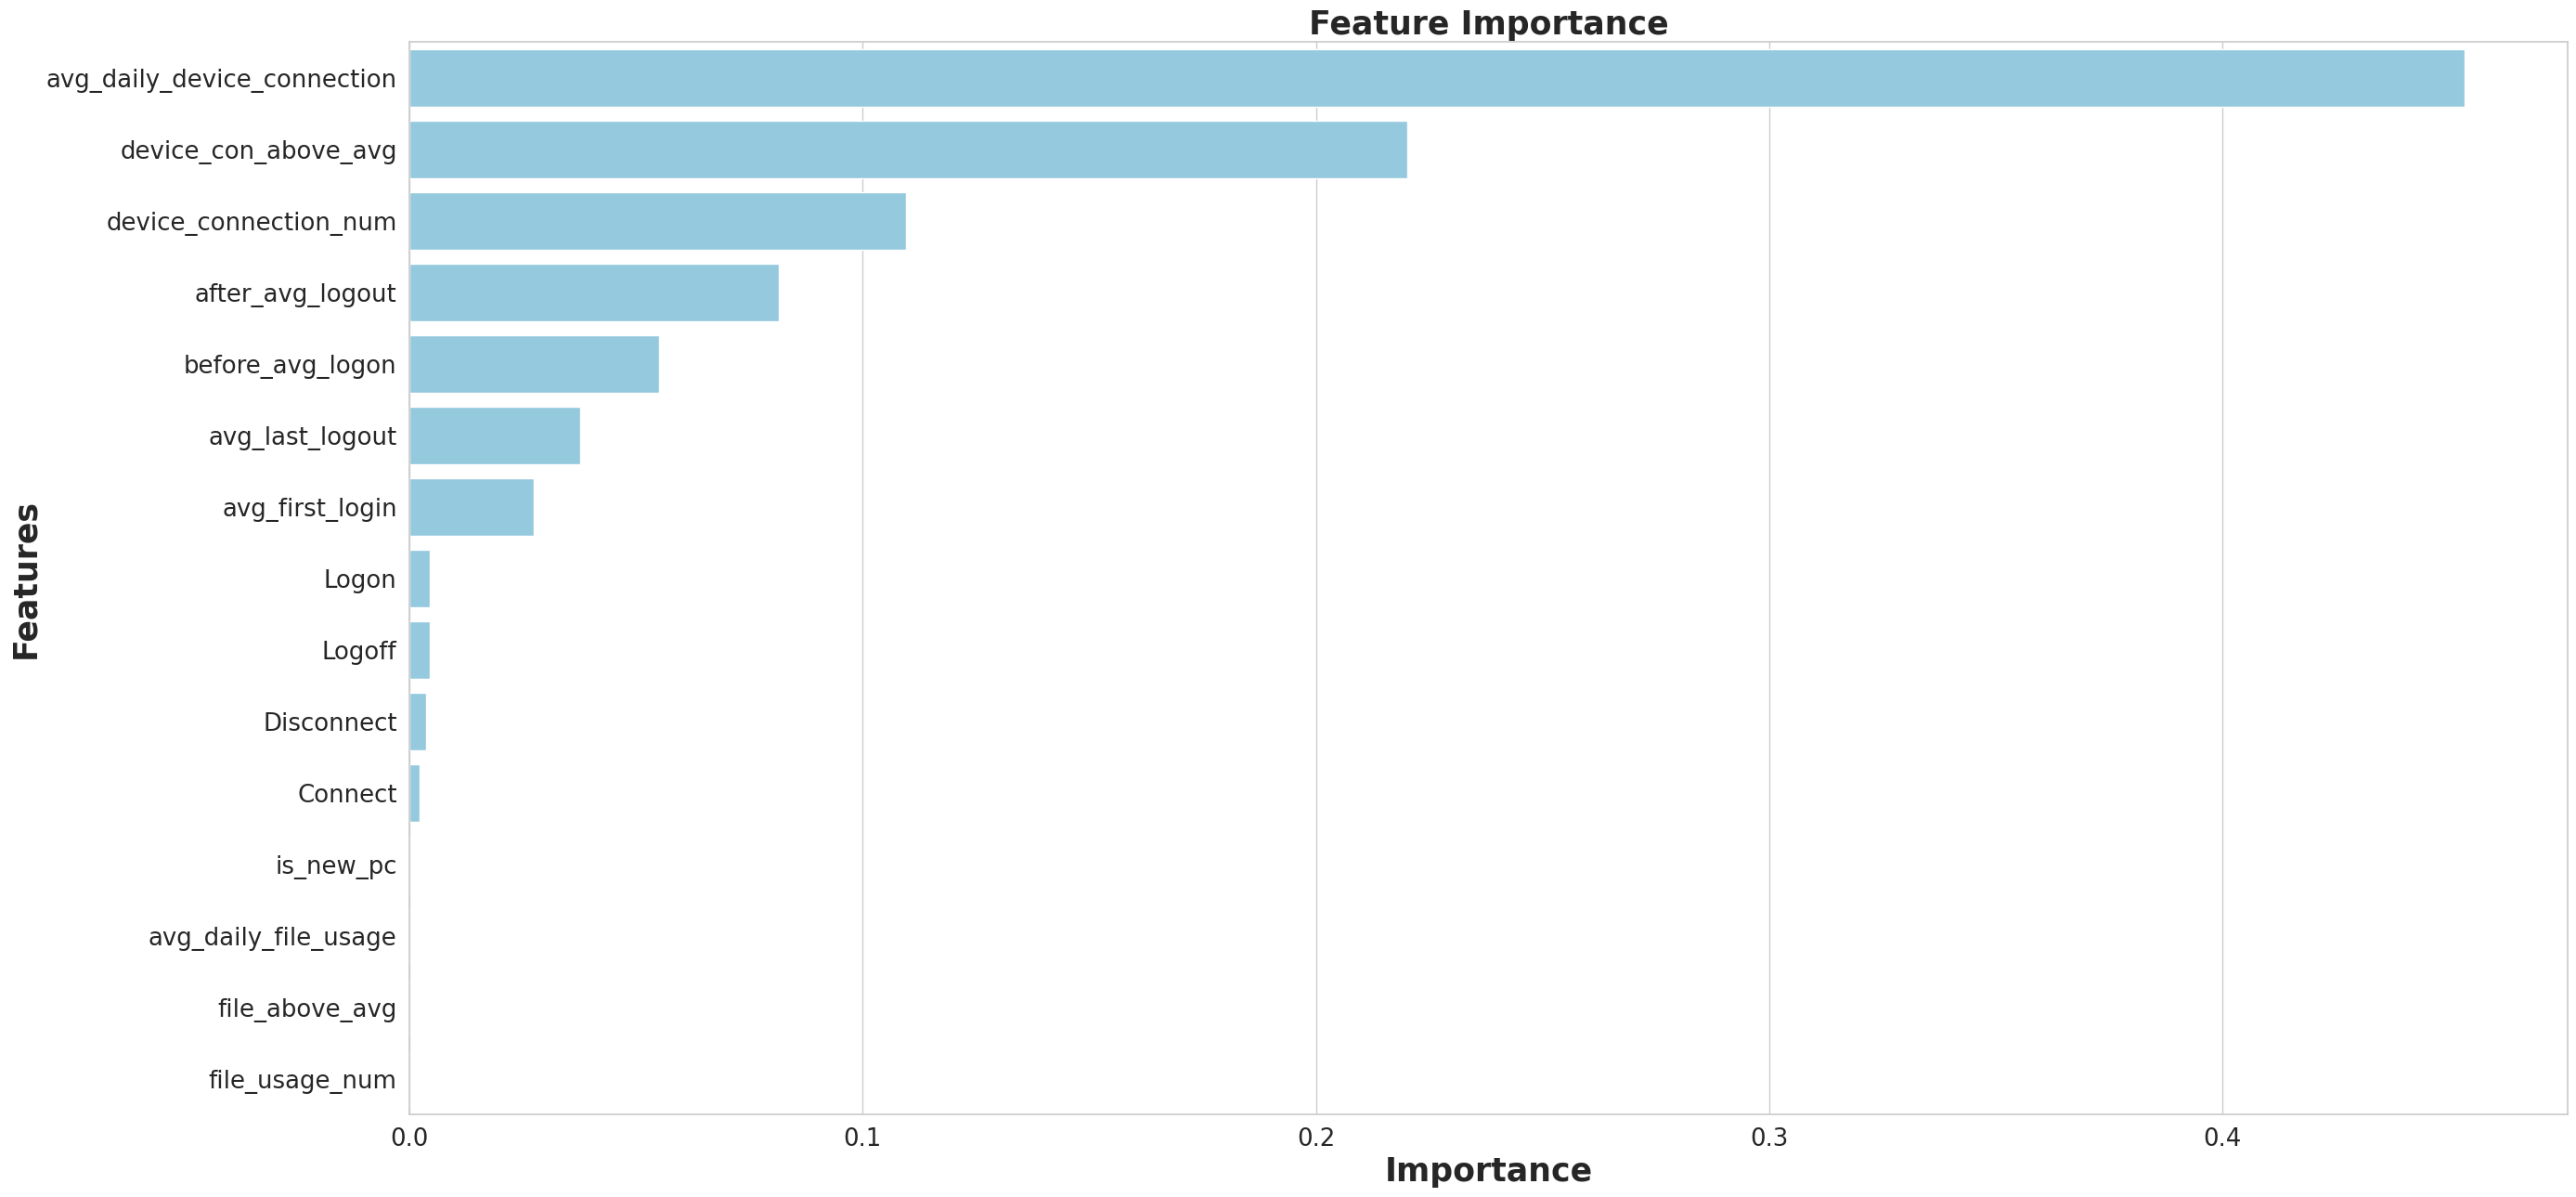

None

,Features,Gini-Importance
0,avg_daily_device_connection,0.453401
1,device_con_above_avg,0.220169
2,device_connection_num,0.109477
3,after_avg_logout,0.081563
4,before_avg_logon,0.055067
5,avg_last_logout,0.037633
6,avg_first_login,0.027495
7,Logon,0.004541
8,Logoff,0.004505
9,Disconnect,0.003772


In [ ]:
import seaborn as sns
from matplotlib import pyplot as plt

feats = {}
for feature, importance in zip(X.columns, rfc.feature_importances_):
    feats[feature] = importance
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
importances = importances.sort_values(by='Gini-Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})
sns.set(font_scale = 5)
sns.set(style="whitegrid", color_codes=True, font_scale = 1.7)
fig, ax = plt.subplots()
fig.set_size_inches(30,15)
sns.barplot(x=importances['Gini-Importance'], y=importances['Features'], data=importances, color='skyblue')
plt.xlabel('Importance', fontsize=25, weight = 'bold')
plt.ylabel('Features', fontsize=25, weight = 'bold')
plt.title('Feature Importance', fontsize=25, weight = 'bold')
display(plt.show())
display(importances)

In [39]:
(1687921 - 107) / 1687921

0.999936608407621